In [71]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Libaries to help with data visualization
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt # for plotting
import seaborn as sns           # for plotting
sns.set_style('darkgrid')

# To tune model, get different metric scores, and split data
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, KFold

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, OneHotEncoder

# To impute missing values
from sklearn.impute import SimpleImputer

# To do hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

# For tuning model hyperparameters with RandomizedSearchCV.
from scipy.stats import uniform, randint

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)

# To suppress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To help with model building
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    BaggingRegressor,
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
    StackingRegressor,
)
from xgboost import XGBRegressor

# To suppress scientific notations
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
input_dir='/kaggle/input/'
input_dir='../Data/'
import os
for dirname, _, filenames in os.walk(input_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

../Data/sample_submission.csv
../Data/test.csv
../Data/train.csv
../Data/training_extra.csv


In [2]:
path=input_dir + 'playground-series-s5e2/'
path=input_dir
columns = ('id', 'brand', 'material', 'size', 'compartments', 'laptop_compartment', 'waterproof', 'style', 'colour', 'weight_capacity', 'price')
# Upper case constants for variables.
for (v, w) in zip(map(str.upper, columns), columns):
    exec("%s = '%s'" % (v, w))
# Read in the data.
train_df = pd.read_csv(
    path + 'train.csv',                                # Path to input file.
    header = 0,                                        # Header in line 0.
    names = columns,                                   # Column labels defined.
    index_col = ID,                                    # ID column used for index.
    usecols = columns,                                 # Specify colomns to import.
    skipinitialspace=True,                             # Skip space around ends.
    encoding = "ascii",                                # Assume ascii encoding for input data.
)
train_extra_df = pd.read_csv(
    path + 'training_extra.csv',                       # Path to input file.
    header = 0,                                        # Header in line 0.
    names = columns,                                   # Column labels defined.
    index_col = ID,                                    # ID column used for index.
    usecols = columns,                                 # Specify colomns to import.
    skipinitialspace=True,                             # Skip space around ends.
    encoding = "ascii",                                # Assume ascii encoding for input data.
)
test_df = pd.read_csv(
    path + 'test.csv',                                 # Path to input file.
    header = 0,                                        # Header in line 0.
    names = columns[:-1],                              # Column labels defined.
    index_col = ID,                                    # ID column used for index.
    usecols = columns[:-1],                            # Specify colomns to import.
    skipinitialspace=True,                             # Skip space around ends.
    encoding = "ascii",                                # Assume ascii encoding for input data.
)

In [3]:
train_df.shape,train_extra_df.shape,test_df.shape

((300000, 10), (3694318, 10), (200000, 9))

In [4]:
train_df.duplicated().sum(),train_extra_df.duplicated().sum(),test_df.duplicated().sum()

(0, 0, 0)

In [5]:
(train_extra_df.isna().sum(axis=1)>0).sum()/train_extra_df.shape[0]*100,(train_df.isna().sum(axis=1)>0).sum()/train_df.shape[0]*100,(test_df.isna().sum(axis=1)>0).sum()/test_df.shape[0]*100

(17.662285704695698, 17.771333333333335, 17.711)

In [6]:
train_all = pd.concat([train_df,train_extra_df], ignore_index=True)
train_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3994318 entries, 0 to 3994317
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   brand               object 
 1   material            object 
 2   size                object 
 3   compartments        float64
 4   laptop_compartment  object 
 5   waterproof          object 
 6   style               object 
 7   colour              object 
 8   weight_capacity     float64
 9   price               float64
dtypes: float64(3), object(7)
memory usage: 304.7+ MB


In [7]:
train_all.isna().sum()/train_all.shape[0]*100

brand                3.173
material             2.778
size                 2.198
compartments         0.000
laptop_compartment   2.467
waterproof           2.361
style                2.608
colour               3.345
weight_capacity      0.045
price                0.000
dtype: float64

In [8]:
train_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3994318 entries, 0 to 3994317
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   brand               object 
 1   material            object 
 2   size                object 
 3   compartments        float64
 4   laptop_compartment  object 
 5   waterproof          object 
 6   style               object 
 7   colour              object 
 8   weight_capacity     float64
 9   price               float64
dtypes: float64(3), object(7)
memory usage: 304.7+ MB


In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, 300000 to 499999
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   brand               193773 non-null  object 
 1   material            194387 non-null  object 
 2   size                195619 non-null  object 
 3   compartments        200000 non-null  float64
 4   laptop_compartment  195038 non-null  object 
 5   waterproof          195189 non-null  object 
 6   style               194847 non-null  object 
 7   colour              193215 non-null  object 
 8   weight_capacity     199923 non-null  float64
dtypes: float64(2), object(7)
memory usage: 15.3+ MB


In [10]:
# Temporary null handling
STRING_COLS = [BRAND, MATERIAL, SIZE, LAPTOP_COMPARTMENT, WATERPROOF, STYLE,COLOUR]
NUM_COLS = [COMPARTMENTS, WEIGHT_CAPACITY]
#for COL in STRING_COLS:
#    train_df[COL] = train_df[COL].where(train_df[COL].notna(), train_df[COL].mode())
#    train_extra_df[COL] = train_extra_df[COL].where(train_extra_df[COL].notna(), train_extra_df[COL].mode())
#    test_df[COL] = test_df[COL].where(test_df[COL].notna(), test_df[COL].mode())
#for COL in NUM_COLS:
#    train_df[COL] = train_df[COL].where(train_df[COL].notna(), train_df[COL].mean())
#    train_extra_df[COL] = train_extra_df[COL].where(train_extra_df[COL].notna(), train_extra_df[COL].mean())
#    test_df[COL] = test_df[COL].where(test_df[COL].notna(), test_df[COL].mean())
# Could we use modelling to imput - similar to shinkansen project?

In [11]:
train_df.isna().sum().sum(),train_extra_df.isna().sum().sum(),test_df.isna().sum().sum(),train_all.isna().sum().sum()

(57199, 700768, 38009, 757967)

In [12]:
train_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3994318 entries, 0 to 3994317
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   brand               object 
 1   material            object 
 2   size                object 
 3   compartments        float64
 4   laptop_compartment  object 
 5   waterproof          object 
 6   style               object 
 7   colour              object 
 8   weight_capacity     float64
 9   price               float64
dtypes: float64(3), object(7)
memory usage: 304.7+ MB


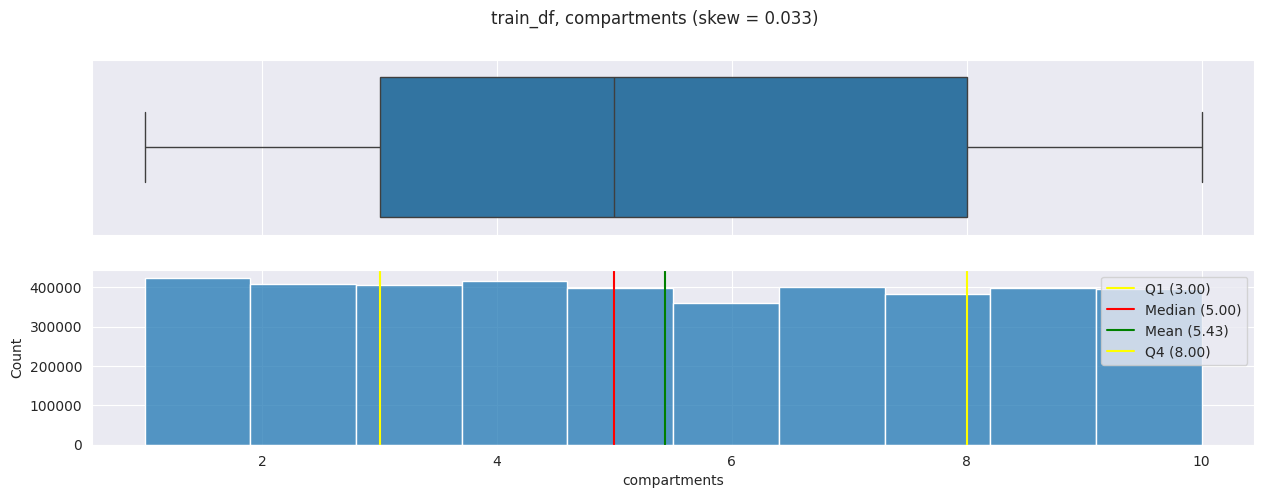

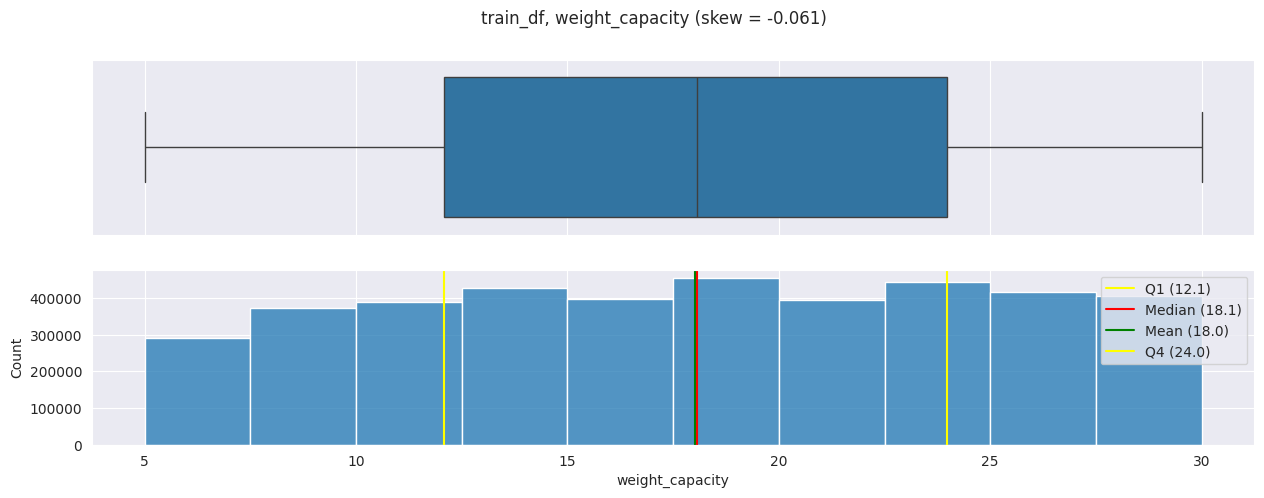

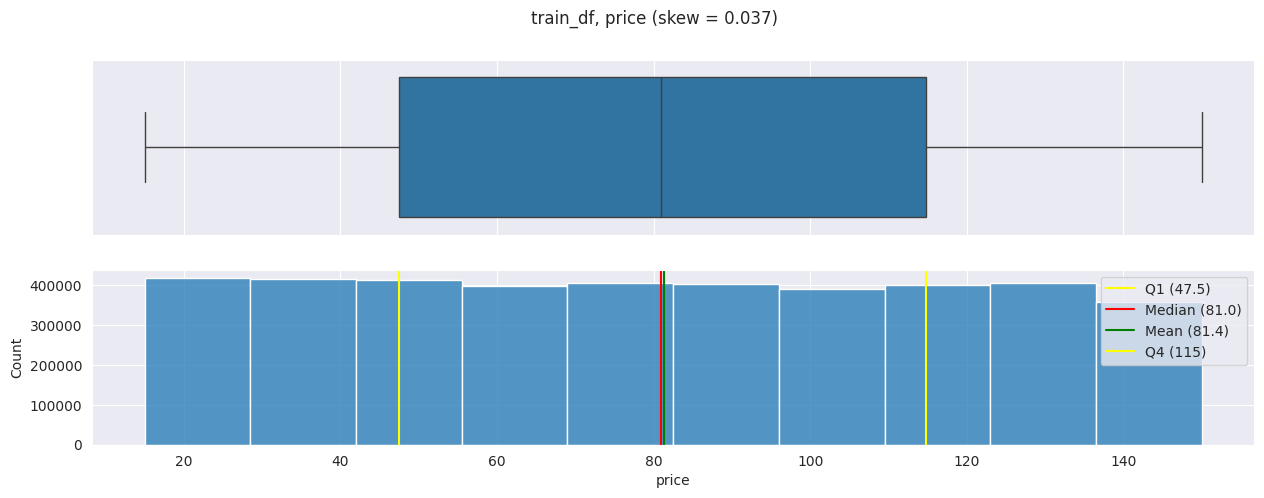

In [13]:
def plot_dist(data, w=15, h=5, nbins=10, title=None, xlabel=None, ylabel=None):
    fig, (axsU, axsL) = plt.subplots(2, 1, figsize=(w,h), sharex=True)
    skew = f"(skew = {data.skew():#,.2g}".removesuffix(".") + ")"
    # Add title
    if (title):
        fig.suptitle(f"{title} {skew}")
    else:
        fig.suptitle(f"Distribution of {data.name} {skew}")
    sns.histplot(x=data,ax=axsL, kde=False, bins=nbins)
    sns.boxplot(x=data,ax=axsU)
    # Calculate mean and median and add them as labels.
    q25, median, q75, mean = (data.quantile(0.25), data.median(), data.quantile(0.75), data.mean())
    plt.axvline(q25, color='yellow', label=f"Q1 ({q25:#,.3g}".removesuffix(".") + ")")
    plt.axvline(median, color='red', label=f"Median ({median:#,.3g}".removesuffix(".") + ")")
    plt.axvline(mean, color='green', label=f"Mean ({mean:#,.3g}".removesuffix(".") + ")")
    plt.axvline(q75, color='yellow', label=f"Q4 ({q75:#,.3g}".removesuffix(".") + ")")
    plt.legend(loc='upper right', fontsize='medium')
    # Add labels on axes.
    if (xlabel): plt.xlabel(xlabel) 
    if (ylabel): plt.ylabel(ylabel)
    plt.show()

for COL in NUM_COLS:
    plot_dist(train_all[COL], title=f"train_df, {COL}")
plot_dist(train_all[PRICE], title=f"train_df, {PRICE}")

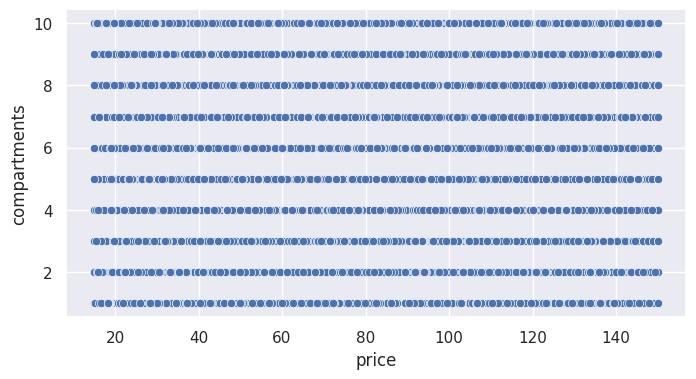

In [14]:
sns.set(rc={"figure.figsize": (8, 4)})

# Price vs Compartments
sns.scatterplot(data=train_all, x=PRICE, y=COMPARTMENTS);


In [15]:
train_all[BRAND].value_counts()

brand
Under Armour    801035
Adidas          797000
Nike            764407
Puma            755778
Jansport        749340
Name: count, dtype: int64

In [16]:
#columns = ('id', 'brand', 'material', 'size', 'compartments', 'laptop_compartment', 'waterproof', 'style', 'colour', 'weight_capacity', 'price')
#sns.scatterplot(data=train_all, x=PRICE, y=WEIGHT_CAPACITY, hue=SIZE);

In [17]:
#sns.scatterplot(data=train_all, x=PRICE, y=WEIGHT_CAPACITY, hue=BRAND);

In [18]:
#sns.scatterplot(data=train_all, x=PRICE, y=WEIGHT_CAPACITY, hue=STYLE);

In [19]:
#sns.scatterplot(data=train_all, x=PRICE, y=WEIGHT_CAPACITY, hue=WATERPROOF);

In [20]:
#sns.scatterplot(data=train_all, x=PRICE, y=WEIGHT_CAPACITY, hue=LAPTOP_COMPARTMENT);

# Split into training, testing and validation data

In [21]:
# Dividing train data into X and y

#X = train_all.drop([PRICE], axis=1)
#y = train_all[PRICE]
X = train_df.drop([PRICE], axis=1)
y = train_df[PRICE]
test = test_df.copy()

In [22]:
# Splitting data into training and validation set:

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1)

X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=1
)

print(X_train.shape, X_val.shape, X_test.shape)

(180000, 9) (60000, 9) (60000, 9)


# Inpute missinga data

In [23]:
imputer = SimpleImputer(strategy="median")

In [24]:
X_train.head()

,brand,material,size,compartments,laptop_compartment,waterproof,style,colour,weight_capacity
id,,,,,,,,,
5666,Adidas,Canvas,Medium,5.000,No,Yes,Backpack,Black,16.875
154895,Nike,Nylon,Large,8.000,Yes,Yes,Tote,Gray,13.611
214831,Puma,Canvas,Small,4.000,No,No,Backpack,Green,12.527
270578,Puma,Nylon,Medium,8.000,Yes,No,Tote,Gray,18.838
156435,Jansport,Canvas,Small,10.000,NaN,Yes,Messenger,Blue,21.965


In [25]:
# Fit and transform the train data
# NB. Here, using median from X_train to impute X_val and X_test. Is that appropriate?
imp = pd.DataFrame(imputer.fit_transform(X_train[NUM_COLS]), columns=NUM_COLS, index=X_train.index)
X_train.update(imp, overwrite=False)

# Transform the validation data
imp = pd.DataFrame(imputer.transform(X_val[NUM_COLS]), columns=NUM_COLS, index=X_val.index)
X_val.update(imp, overwrite=False)

# Transform the test data
imp = pd.DataFrame(imputer.transform(X_test[NUM_COLS]), columns=NUM_COLS, index=X_test.index)
X_test.update(imp, overwrite=False)

In [26]:
# Transform the submission test data. Here, also using the median from the X_test data. Is that appropriate?
imp = pd.DataFrame(imputer.transform(test[NUM_COLS]), columns=NUM_COLS, index=test.index)
test.update(imp, overwrite=False)

In [27]:
X_train[NUM_COLS].isna().sum(),X_val[NUM_COLS].isna().sum(),X_test[NUM_COLS].isna().sum()

(compartments       0
 weight_capacity    0
 dtype: int64,
 compartments       0
 weight_capacity    0
 dtype: int64,
 compartments       0
 weight_capacity    0
 dtype: int64)

In [28]:
imputer = SimpleImputer(strategy="most_frequent")

In [29]:
# Fit and transform the train data
imp = pd.DataFrame(imputer.fit_transform(X_train[STRING_COLS]), columns=STRING_COLS, index=X_train.index)
X_train.update(imp, overwrite=False)

# Transform the validation data
imp = pd.DataFrame(imputer.transform(X_val[STRING_COLS]), columns=STRING_COLS, index=X_val.index)
X_val.update(imp, overwrite=False)

# Transform the test data
imp = pd.DataFrame(imputer.transform(X_test[STRING_COLS]), columns=STRING_COLS, index=X_test.index)
X_test.update(imp, overwrite=False)

In [30]:
# Transform the test data
# Here, also using the median from the X_test data. Is that appropriate?
imp = pd.DataFrame(imputer.transform(test[STRING_COLS]), columns=STRING_COLS, index=test.index)
test.update(imp, overwrite=False)

In [31]:
X_train.isna().sum().sum(),X_val.isna().sum().sum(),X_test.isna().sum().sum(),test.isna().sum().sum()

(0, 0, 0, 0)

# Convert categorial data to numbers

## Using get_dummies

In [32]:
# NB. Convert the COMPARTMENTS column to string before calling get_dummies to also make it stupid ;)
X_train = pd.get_dummies(X_train.assign(**{COMPARTMENTS: lambda x: x[COMPARTMENTS].astype(int).transform(str)}),drop_first=True,dtype=int)
X_train.rename(columns=lambda x: x.replace(" ","_"), inplace=True)
X_val = pd.get_dummies(X_val.assign(**{COMPARTMENTS: lambda x: x[COMPARTMENTS].astype(int).transform(str)}),drop_first=True,dtype=int)
X_val.rename(columns=lambda x: x.replace(" ","_"), inplace=True)
X_test = pd.get_dummies(X_test.assign(**{COMPARTMENTS: lambda x: x[COMPARTMENTS].astype(int).transform(str)}),drop_first=True,dtype=int)
X_test.rename(columns=lambda x: x.replace(" ","_"), inplace=True)
X_train.head()

,weight_capacity,brand_Jansport,brand_Nike,brand_Puma,brand_Under_Armour,material_Leather,material_Nylon,material_Polyester,size_Medium,size_Small,compartments_10,compartments_2,compartments_3,compartments_4,compartments_5,compartments_6,compartments_7,compartments_8,compartments_9,laptop_compartment_Yes,waterproof_Yes,style_Messenger,style_Tote,colour_Blue,colour_Gray,colour_Green,colour_Pink,colour_Red
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5666,16.875,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
154895,13.611,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0,1,0,0,0
214831,12.527,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
270578,18.838,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0
156435,21.965,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0


In [33]:
# Identical treatment as above.
test = pd.get_dummies(test.assign(**{COMPARTMENTS: lambda x: x[COMPARTMENTS].astype(int).transform(str)}),drop_first=True,dtype=int)
test.rename(columns=lambda x: x.replace(" ","_"), inplace=True)

In [34]:
# Normalise the numeric columns WEIGHT_CAPACITY: z = (x - u) / s
scaler = StandardScaler()

In [35]:
# Fit and transform the train data
X_train = X_train.assign(**{WEIGHT_CAPACITY: scaler.fit_transform(X_train[[WEIGHT_CAPACITY]])})
X_val = X_val.assign(**{WEIGHT_CAPACITY: scaler.transform(X_val[[WEIGHT_CAPACITY]])})
X_test = X_test.assign(**{WEIGHT_CAPACITY: scaler.transform(X_test[[WEIGHT_CAPACITY]])})
X_train.head()

,weight_capacity,brand_Jansport,brand_Nike,brand_Puma,brand_Under_Armour,material_Leather,material_Nylon,material_Polyester,size_Medium,size_Small,compartments_10,compartments_2,compartments_3,compartments_4,compartments_5,compartments_6,compartments_7,compartments_8,compartments_9,laptop_compartment_Yes,waterproof_Yes,style_Messenger,style_Tote,colour_Blue,colour_Gray,colour_Green,colour_Pink,colour_Red
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5666,-0.167,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
154895,-0.636,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0,1,0,0,0
214831,-0.791,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
270578,0.115,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0
156435,0.564,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0


In [36]:
# Fit and transform the train data
# NB. Here, using z = (x - u) / s from X_train to impute X_val and X_test. Is that appropriate?
test = test.assign(**{WEIGHT_CAPACITY: scaler.transform(test[[WEIGHT_CAPACITY]])})

## Alternative method: assign integers to categories

In [121]:
def features_to_numeric(x):
  # BRAND, MATERIAL, SIZE, LAPTOP_COMPARTMENT, WATERPROOF, STYLE, COLOUR
  match x:
    case 'Adidas' | 'Canvas' | 'Large' | 'No' | 'Backpack' | 'Black':
      return 0
    case 'Jansport' | 'Nylon' | 'Medium' | 'Yes' | 'Messenger' | 'Blue':
      return 1
    case 'Nike' | 'Leather' | 'Small' | 'Tote' | 'Gray':
      return 2
    case 'Puma' | 'Polyester' | 'Green':
      return 3
    case 'Under Armour' | 'Pink':
      return 4
    case 'Red':
      return 5
    case _:
      return x

In [122]:
X_train = X_train.assign(**{
  COMPARTMENTS: lambda x: x[COMPARTMENTS].astype(int)
}).assign(**{
  col: lambda x, c=col: [features_to_numeric(y) for y in x[c]] for col in STRING_COLS
})
X_val = X_val.assign(**{
  COMPARTMENTS: lambda x: x[COMPARTMENTS].astype(int)
}).assign(**{
  col: lambda x, c=col: [features_to_numeric(y) for y in x[c]] for col in STRING_COLS
})
X_test = X_test.assign(**{
  COMPARTMENTS: lambda x: x[COMPARTMENTS].astype(int)
}).assign(**{
  col: lambda x, c=col: [features_to_numeric(y) for y in x[c]] for col in STRING_COLS
})

In [123]:
test = test.assign(**{
  COMPARTMENTS: lambda x: x[COMPARTMENTS].astype(int)
}).assign(**{
  col: lambda x, c=col: [features_to_numeric(y) for y in x[c]] for col in STRING_COLS
})

In [124]:
X_train.head()

,brand,material,size,compartments,laptop_compartment,waterproof,style,colour,weight_capacity
id,,,,,,,,,
5666,0,0,1,5,0,1,0,0,16.875
154895,2,1,0,8,1,1,2,2,13.611
214831,3,0,2,4,0,0,0,3,12.527
270578,3,1,1,8,1,0,2,2,18.838
156435,1,0,2,10,1,1,1,1,21.965


In [125]:
# Normalise the numeric columns WEIGHT_CAPACITY: z = round(x) - min, min=5 for WEIGHT_CAPACITY
def weight_transformer(x):
    return round(x).astype(int)-5
scaler = FunctionTransformer(weight_transformer)

In [126]:
# Fit and transform the train data
X_train = X_train.assign(**{WEIGHT_CAPACITY: scaler.transform(X_train[[WEIGHT_CAPACITY]])})
X_val = X_val.assign(**{WEIGHT_CAPACITY: scaler.transform(X_val[[WEIGHT_CAPACITY]])})
X_test = X_test.assign(**{WEIGHT_CAPACITY: scaler.transform(X_test[[WEIGHT_CAPACITY]])})
X_train.head()

,brand,material,size,compartments,laptop_compartment,waterproof,style,colour,weight_capacity
id,,,,,,,,,
5666,0,0,1,5,0,1,0,0,12
154895,2,1,0,8,1,1,2,2,9
214831,3,0,2,4,0,0,0,3,8
270578,3,1,1,8,1,0,2,2,14
156435,1,0,2,10,1,1,1,1,17


In [127]:
# Fit and transform the train data
test = pd.DataFrame(scaler.transform(test), columns=test.columns, index=test.index)

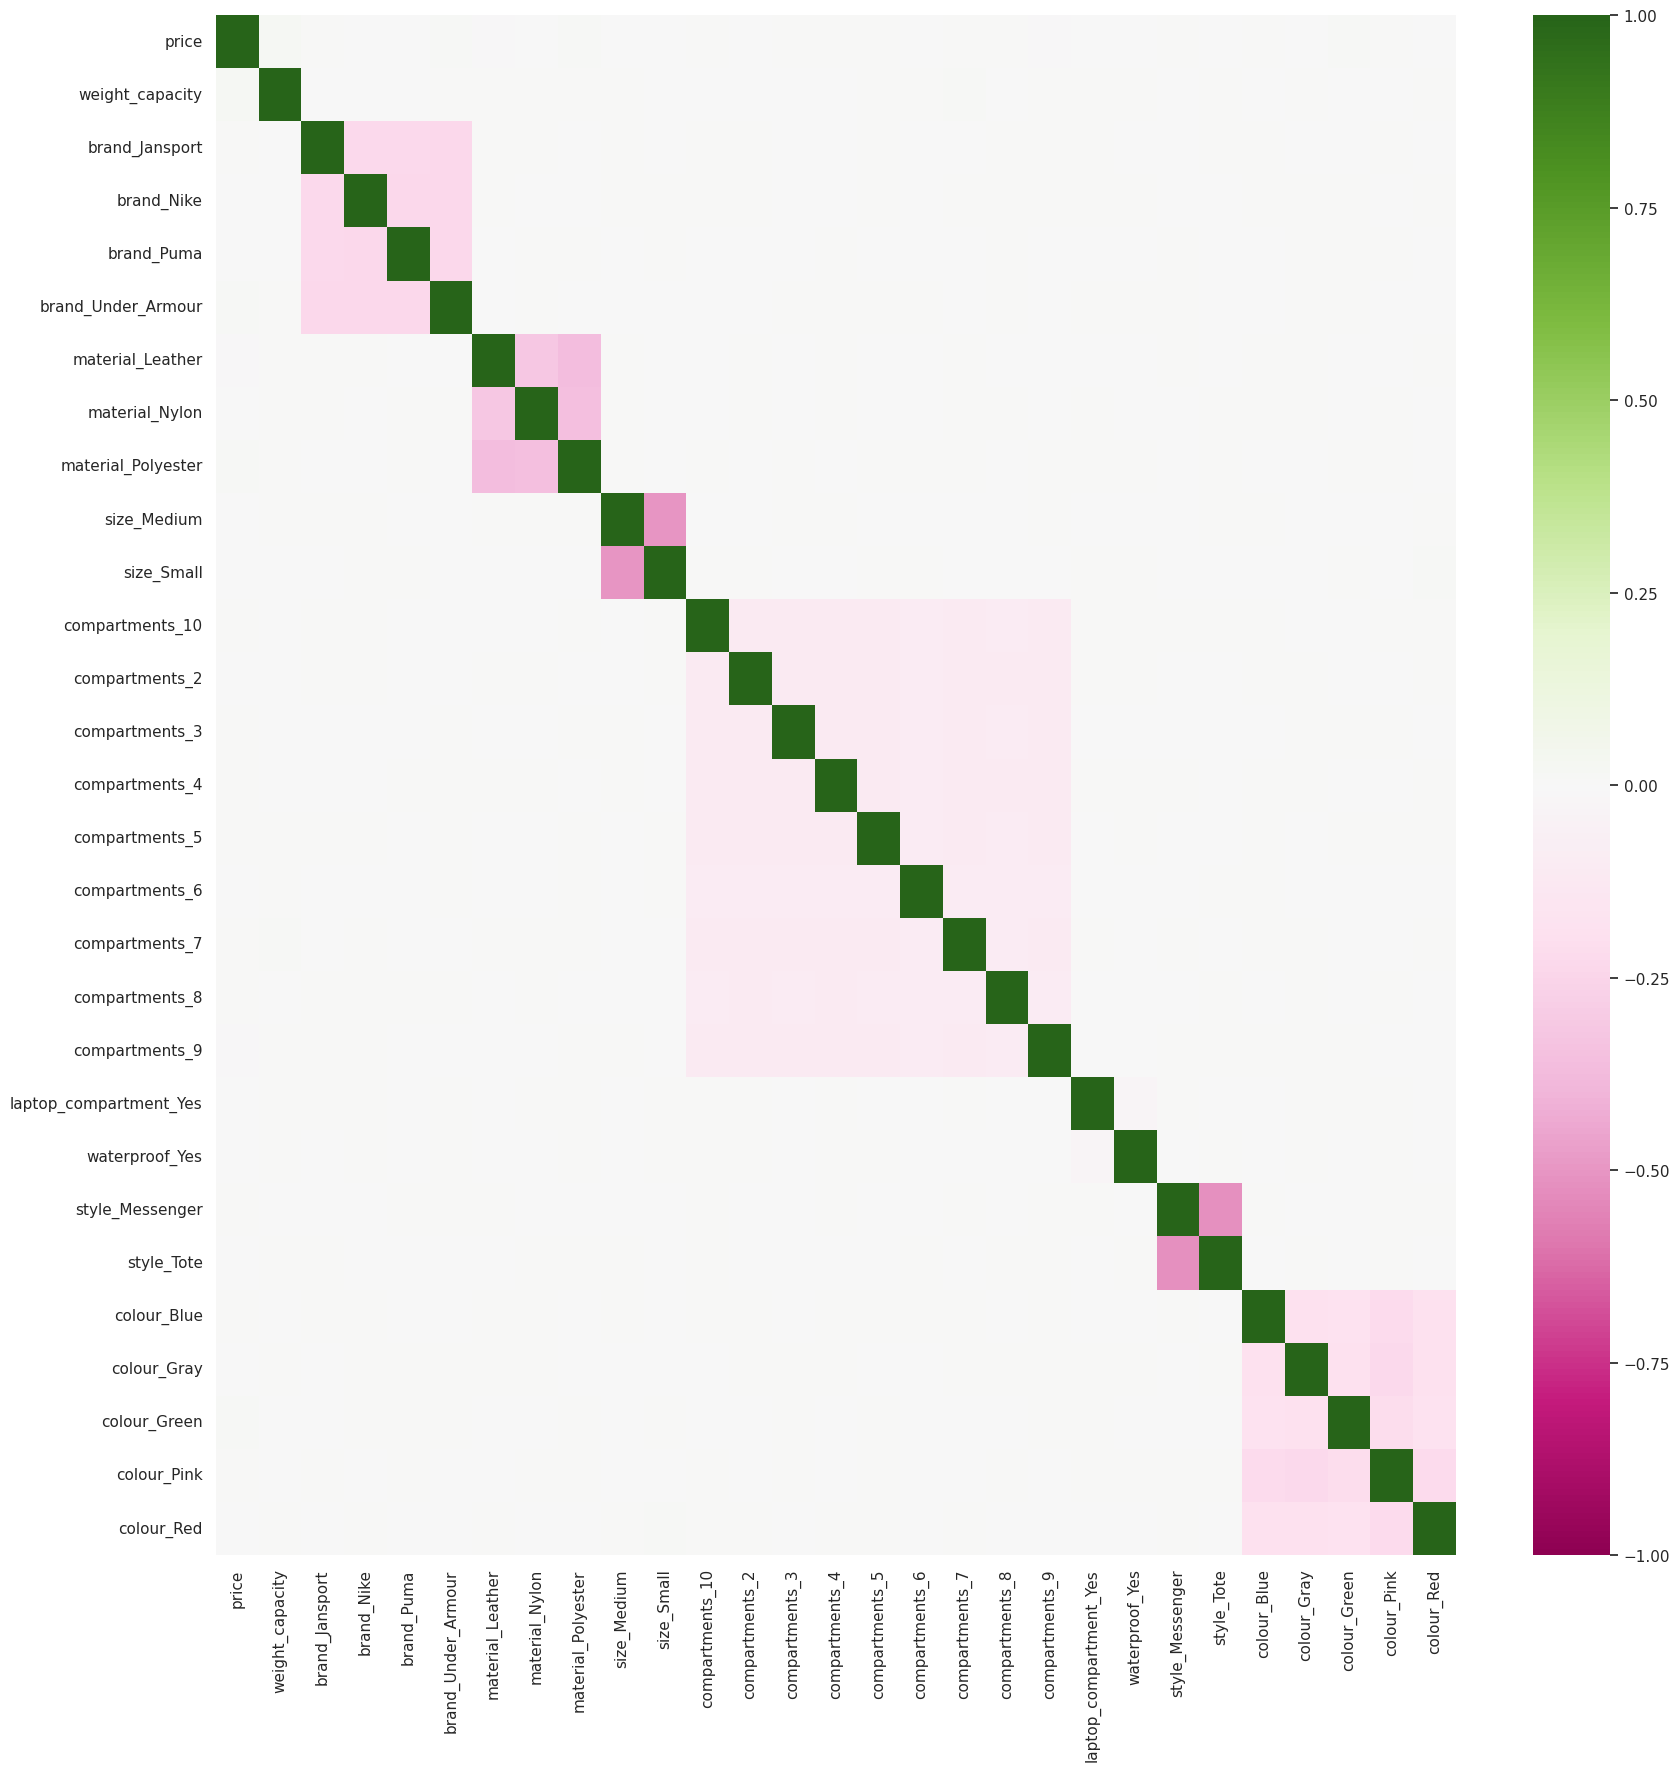

price                     1.000
weight_capacity           0.017
brand_Jansport            0.007
brand_Nike               -0.003
brand_Puma               -0.001
brand_Under_Armour        0.009
material_Leather         -0.014
material_Nylon           -0.007
material_Polyester        0.010
size_Medium              -0.006
size_Small               -0.001
compartments_10           0.001
compartments_2           -0.003
compartments_3            0.001
compartments_4            0.003
compartments_5            0.001
compartments_6           -0.001
compartments_7            0.000
compartments_8            0.006
compartments_9           -0.010
laptop_compartment_Yes   -0.002
waterproof_Yes           -0.003
style_Messenger           0.000
style_Tote               -0.001
colour_Blue               0.007
colour_Gray              -0.007
colour_Green              0.010
colour_Pink               0.003
colour_Red               -0.003
Name: price, dtype: float64

In [37]:
plt.figure(figsize  = (20, 20))
corr=pd.concat([y_train,X_train],axis=1).corr()
sns.heatmap(corr, vmin=-1, vmax=1, annot = False, cmap = "PiYG")#cmap = "YlGnBu")
plt.show()
corr.iloc[:,0]

# Modelling

In [38]:
# Function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


# Function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    r2 = r2_score(target, pred)  # to compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)  # to compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # to compute RMSE
    mae = mean_absolute_error(target, pred)  # to compute MAE

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
        },
        index=[0],
    )

    return df_perf

In [39]:
dtree = DecisionTreeRegressor(random_state=1)
dtree.fit(X_train, y_train)

DecisionTreeRegressor(random_state=1)

In [40]:
dtree_model_train_perf = model_performance_regression(dtree, X_train, y_train)
dtree_model_train_perf

,RMSE,MAE,R-squared,Adj. R-squared
0,0.750,0.016,1.000,1.000


In [41]:
dtree_model_val_perf = model_performance_regression(dtree, X_val, y_val)
dtree_model_val_perf

,RMSE,MAE,R-squared,Adj. R-squared
0,55.983,45.662,-1.050,-1.051


In [42]:
rf_estimator = RandomForestRegressor(random_state=1)
rf_estimator.fit(X_train[:500000], y_train[:500000])

RandomForestRegressor(random_state=1)

In [43]:
rf_estimator_model_train_perf = model_performance_regression(
    rf_estimator, X_train[:500000], y_train[:500000]
)
rf_estimator_model_train_perf

,RMSE,MAE,R-squared,Adj. R-squared
0,15.054,12.761,0.852,0.852


In [44]:
rf_estimator_model_val_perf = model_performance_regression(rf_estimator, X_val, y_val)
rf_estimator_model_val_perf

,RMSE,MAE,R-squared,Adj. R-squared
0,40.278,34.567,-0.061,-0.062


In [45]:
bag_estimator = BaggingRegressor(random_state=1)
bag_estimator.fit(X_train[:500000], y_train[:500000])

BaggingRegressor(random_state=1)

In [46]:
bag_estimator_model_train_perf = model_performance_regression(
    bag_estimator, X_train[:500000], y_train[:500000]
)
bag_estimator_model_train_perf

,RMSE,MAE,R-squared,Adj. R-squared
0,17.608,13.760,0.797,0.797


In [47]:
bag_estimator_model_val_perf = model_performance_regression(bag_estimator, X_val, y_val)
bag_estimator_model_val_perf

,RMSE,MAE,R-squared,Adj. R-squared
0,41.962,35.597,-0.152,-0.152


In [48]:
ab_regressor = AdaBoostRegressor(random_state=1)
ab_regressor.fit(X_train, y_train)

AdaBoostRegressor(random_state=1)

In [49]:
ab_regressor_model_train_perf = model_performance_regression(
    ab_regressor, X_train, y_train
)
ab_regressor_model_train_perf

,RMSE,MAE,R-squared,Adj. R-squared
0,39.063,33.816,0.001,0.000


In [50]:
ab_regressor_model_val_perf = model_performance_regression(
    ab_regressor, X_val, y_val)
ab_regressor_model_val_perf

,RMSE,MAE,R-squared,Adj. R-squared
0,39.086,33.861,0.001,0.000


In [51]:
gb_estimator = GradientBoostingRegressor(random_state=1)
gb_estimator.fit(X_train, y_train)

GradientBoostingRegressor(random_state=1)

In [52]:
gb_estimator_model_train_perf = model_performance_regression(
    gb_estimator, X_train, y_train
)
gb_estimator_model_train_perf

,RMSE,MAE,R-squared,Adj. R-squared
0,38.991,33.749,0.004,0.004


In [53]:
gb_estimator_model_val_perf = model_performance_regression(
    gb_estimator, X_val, y_val)
gb_estimator_model_val_perf

,RMSE,MAE,R-squared,Adj. R-squared
0,39.073,33.843,0.001,0.001


In [54]:
xgb_estimator = XGBRegressor(random_state=1)
xgb_estimator.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=1, ...)

In [55]:
xgb_estimator_model_train_perf = model_performance_regression(
    xgb_estimator, X_train, y_train
)
xgb_estimator_model_train_perf

,RMSE,MAE,R-squared,Adj. R-squared
0,38.060,32.854,0.051,0.051


In [56]:
xgb_estimator_model_val_perf = model_performance_regression(
    xgb_estimator, X_val, y_val)
xgb_estimator_model_val_perf

,RMSE,MAE,R-squared,Adj. R-squared
0,39.319,33.969,-0.011,-0.012


In [57]:
# Training performance comparison

models_train_comp_df = pd.concat(
    [
        rf_estimator_model_train_perf.T,
        bag_estimator_model_train_perf.T,
        ab_regressor_model_train_perf.T,
        gb_estimator_model_train_perf.T,
        xgb_estimator_model_train_perf.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Random forest",
    "Bagging Regressor",
    "Adaboost",
    "Gradient Boosting",
    "Xgboost",
]
print("Training performance comparison:")
models_train_comp_df.T

Training performance comparison:


,RMSE,MAE,R-squared,Adj. R-squared
Random forest,15.054,12.761,0.852,0.852
Bagging Regressor,17.608,13.760,0.797,0.797
Adaboost,39.063,33.816,0.001,0.000
Gradient Boosting,38.991,33.749,0.004,0.004
Xgboost,38.060,32.854,0.051,0.051


In [62]:
# Tuning Gradient Boosting!
# randint(low,high) => {low,high-1}
# uniform(loc,scale) => [loc, loc + scale]
# Setting up parameter grid to tune the hyperparameters.
param_distributions = {
    'loss': ['squared_error', 'absolute_error', 'huber', 'quantile'],  # {'squared_error', 'absolute_error', 'huber', 'quantile'}, default='squared_error'
    'learning_rate': uniform(0,1),                                     # float, default=0.1, [0.0, inf)
    'n_estimators': randint(1,501),                                    # default=100, [1, inf)
    'subsample': uniform(0,1),                                         # default=1.0, (0.0, 1], if <1 => Stochastic Gradient Boosting
    'criterion': ['friedman_mse', 'squared_error'],                    # {'friedman_mse', 'squared_error'}, default='friedman_mse'
    'min_samples_split': randint(2,101),  #uniform(0,1)                # int or float, default=2, [2, inf) if int, (0.0, 1.0] if float
    'max_depth': randint(1,101),                                       # int or None, default=3, [1, inf)
    'random_state': [1],                                               # For setting random state for prediction algorithm.
    'verbose': [False],                                                # For preventing boring output from the prediction algorithm.
}
# Performing 3-fold cross-validation to tune the hyperparameters.
gb_search = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(random_state=1),
    param_distributions=param_distributions,
    n_iter=100,
    #refit="r2",
    #scoring=["r2"],
    cv=3,
    n_jobs=-1,
    #pre_dispatch=8,
)

# Fitting the data.
gb_search.fit(X_train, y_train)

# Best score (estimator’s score method is used if scoring and refit parameters are not set).
print(gb_search.best_score_)

# Combination of parameters that gave the best score.
print(gb_search.best_params_)
#-0.0030350339068206575
#{'criterion': 'squared_error', 'learning_rate': 0.12627690652125367, 'loss': 'absolute_error', 'max_depth': 8, 'min_samples_split': 2,
#'n_estimators': 159, 'random_state': 1, 'subsample': 0.29988187225329466, 'verbose': False}
#0.0008386802665372173
#{'criterion': 'squared_error', 'learning_rate': 0.26974140047756384, 'loss': 'squared_error', 'max_depth': 5, 'min_samples_split': 7,
#'n_estimators': 95, 'random_state': 1, 'subsample': 0.42478570715388675, 'verbose': False}
#-0.034658773325968305
#{'criterion': 'squared_error', 'learning_rate': 0.035043461113681285, 'loss': 'huber', 'max_depth': 14, 'min_samples_split': 80,
#'n_estimators': 488, 'random_state': 1, 'subsample': 0.4538298246330287, 'verbose': False}
0.000528449699085313
#{'criterion': 'friedman_mse', 'learning_rate': 0.9565647531101563, 'loss': 'huber', 'max_depth': 1, 'min_samples_split': 20, 
#'n_estimators': 270, 'random_state': 1, 'subsample': 0.6351351919566911, 'verbose': False}

0.000528449699085313
{'criterion': 'friedman_mse', 'learning_rate': 0.9565647531101563, 'loss': 'huber', 'max_depth': 1, 'min_samples_split': 20, 'n_estimators': 270, 'random_state': 1, 'subsample': 0.6351351919566911, 'verbose': False}


In [63]:
gb_estimator_tuned = GradientBoostingRegressor(**gb_search.best_params_)
gb_estimator_tuned.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.9565647531101563, loss='huber',
                          max_depth=1, min_samples_split=20, n_estimators=270,
                          random_state=1, subsample=0.6351351919566911,
                          verbose=False)

In [64]:
gb_estimator_model_tuned_train_perf = model_performance_regression(
    gb_estimator_tuned, X_train, y_train
)
gb_estimator_model_tuned_train_perf

,RMSE,MAE,R-squared,Adj. R-squared
0,39.014,33.757,0.003,0.003


In [65]:
gb_estimator_model_tuned_val_perf = model_performance_regression(
    gb_estimator_tuned, X_val, y_val)
gb_estimator_model_tuned_val_perf

,RMSE,MAE,R-squared,Adj. R-squared
0,39.080,33.839,0.001,0.001


In [66]:
# Tuning Adaboost!
# randint(low,high) => {low,high-1}
# uniform(loc,scale) => [loc, loc + scale]
# Setting up parameter grid to tune the hyperparameters.
param_distributions = {
    'n_estimators': randint(1,701),                                    # int, default=50, [1, inf)
    'learning_rate': uniform(0,1),                                     # float, default=0.1, [0.0, inf)
    'loss': ['linear', 'square', 'exponential'],                       # {'linear', 'square', 'exponential'}, default='linear'
    'random_state': [1],                                               # For setting random state for prediction algorithm.
}
# Performing 3-fold cross-validation to tune the hyperparameters.
ab_search = RandomizedSearchCV(
    estimator=AdaBoostRegressor(random_state=1),
    param_distributions=param_distributions,
    n_iter=100,
    #refit="r2",
    #scoring=["r2"],
    cv=3,
    n_jobs=-1,
    #pre_dispatch=8,

)

# Fitting the data.
ab_search.fit(X_train, y_train)

# Best score (estimator’s score method is used if scoring and refit parameters are not set).
print(ab_search.best_score_)

# Combination of parameters that gave the best score.
print(ab_search.best_params_)
#0.0008835919355247487
#{'learning_rate': 0.7197812630600714, 'loss': 'linear', 'n_estimators': 488, 'random_state': 1}
#0.0009230570448259812
#{'learning_rate': 0.5543076725399341, 'loss': 'linear', 'n_estimators': 381, 'random_state': 1}

0.0005983987476965898
{'learning_rate': 0.11960935593034949, 'loss': 'linear', 'n_estimators': 199, 'random_state': 1}


In [67]:
ab_regressor_tuned = AdaBoostRegressor(**ab_search.best_params_)
ab_regressor_tuned.fit(X_train, y_train)

AdaBoostRegressor(learning_rate=0.11960935593034949, n_estimators=199,
                  random_state=1)

In [68]:
ab_regressor_model_tuned_train_perf = model_performance_regression(
    ab_regressor_tuned, X_train, y_train
)
ab_regressor_model_tuned_train_perf

,RMSE,MAE,R-squared,Adj. R-squared
0,39.055,33.815,0.001,0.001


In [69]:
ab_regressor_model_tuned_val_perf = model_performance_regression(
    ab_regressor_tuned, X_val, y_val)
ab_regressor_model_tuned_val_perf

,RMSE,MAE,R-squared,Adj. R-squared
0,39.081,33.860,0.001,0.000


In [ ]:
# Tuning Xgboost!
# randint(low,high) => {low,high-1}
# uniform(loc,scale) => [loc, loc + scale]
# Setting up parameter grid to tune the hyperparameters.
param_distributions = {
    'learning_rate': uniform(0,1),                                     # Boosting learning rate (xgb’s “eta”).
    'n_estimators': randint(1,501),                                    # Number of gradient boosted trees. Equivalent to number of boosting rounds.
    'max_depth': randint(1,101),                                       # Maximum tree depth for base learners.
    'random_state': [1],                                               # For setting random state for prediction algorithm.
}
# Performing 3-fold cross-validation to tune the hyperparameters.
xgb_search = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=1),
    param_distributions=param_distributions,
    n_iter=100,
    #refit="r2",
    #scoring=["r2"],
    cv=3,
    n_jobs=-1,
    #pre_dispatch=8,

)

# Fitting the data.
xgb_search.fit(X_train, y_train)

# Best score (estimator’s score method is used if scoring and refit parameters are not set).
print(xgb_search.best_score_)

# Combination of parameters that gave the best score.
print(xgb_search.best_params_)

In [ ]:
xgb_estimator_tuned = XGBRegressor(**xgb_search.best_params_)
xgb_estimator_tuned.fit(X_train, y_train)

In [ ]:
xgb_estimator_model_tuned_train_perf = model_performance_regression(
    xgb_estimator_tuned, X_train, y_train
)
xgb_estimator_model_tuned_train_perf

In [ ]:
xgb_estimator_model_tuned_val_perf = model_performance_regression(
    xgb_estimator_tuned, X_val, y_val)
xgb_estimator_model_tuned_val_perf

In [ ]:
test.info()

# **Sumbit Best Results**

In [ ]:
prediction = gb_estimator_tuned.predict(test)    # Gradient Boosting
#prediction = ab_regressor_tuned.predict(test)    # Adaboost
#prediction = xgb_estimator_tuned.predict(test)   # Xgboost

In [ ]:
prediction.round()[1]

In [ ]:
submission = pd.read_csv(path + "sample_submission.csv")
submission = pd.DataFrame({
    ID: submission[ID],
    PRICE: prediction.round()
})
display(submission.head())

In [ ]:
submission.shape

In [ ]:
submission.info()

In [ ]:
submission.to_csv('submission.csv', index = False)